%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Shape of the image (87102,)


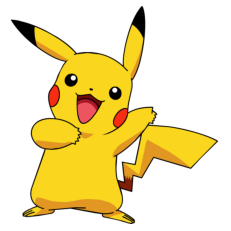

Shape of the image (568976,)


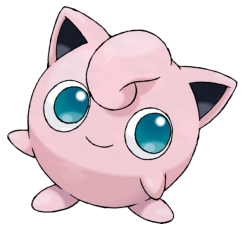

In [1]:
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf

%pylab inline

url_pikachu = r'https://github.com/anisayari/Youtube-apprendre-le-deeplearning-avec-tensorflow/blob/master/%234%20-%20CNN/pikachu.png?raw=true'
resp = requests.get(url_pikachu, stream=True).raw
image_array_pikachu = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_pikachu.shape}')
image_pikachu = cv2.imdecode(image_array_pikachu, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_pikachu, cv2.COLOR_BGR2RGB)) #opencv if BGR color, matplotlib usr RGB so we need to switch otherwise the pikachu will be blue ... O:)
plt.show()

url_rondoudou = r'https://github.com/anisayari/Youtube-apprendre-le-deeplearning-avec-tensorflow/blob/master/%234%20-%20CNN/rondoudou.png?raw=true'
resp = requests.get(url_rondoudou, stream=True).raw
image_array_rondoudou = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_rondoudou.shape}')
image_rondoudou = cv2.imdecode(image_array_rondoudou, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_rondoudou, cv2.COLOR_BGR2RGB))
plt.show()

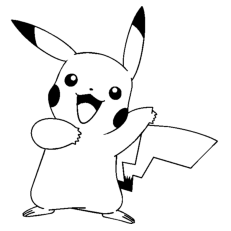

In [3]:
#Convert to black&white
img_bw = cv2.imdecode(image_array_pikachu, cv2.IMREAD_GRAYSCALE)
(thresh, img_bw) = cv2.threshold(img_bw, 127, 255, cv2.THRESH_BINARY)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_bw, cv2.COLOR_BGR2RGB))

[[0 0 0]
 [0 1 0]
 [0 0 0]]


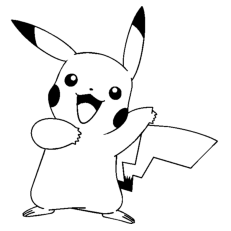

In [4]:
#defining an identity kernel, will change nothing because each pixel will remain with is value
kernel = np.matrix([[0,0,0],[0,1,0],[0,0,0]])
print(kernel)
img_1 = cv2.filter2D(img_bw, -1, kernel)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))

[[-10   0  10]
 [-10   0  10]
 [-10   0  10]]


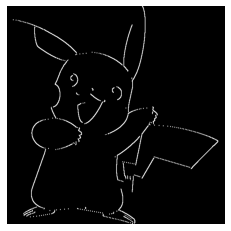

In [5]:
#defining a vertical edge detection kernel 
kernel = np.matrix([[-10,0,10],[-10,0,10],[-10,0,10]])
print(kernel)
img_1 = cv2.filter2D(img_bw, -1, kernel)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))

[[ 10  10  10]
 [  0   0   0]
 [-10 -10 -10]]


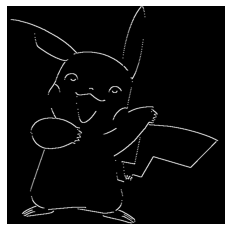

In [6]:
#defining an horizontal edge detection kernel 
kernel = np.matrix([[10,10,10],[0,0,0],[-10,-10,-10]])
print(kernel)
img_1 = cv2.filter2D(img_bw, -1, kernel)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))

In [7]:
#Import dataset
import pathlib
import os
data_dir = tf.keras.utils.get_file(
    "dataset.zip",
    "https://github.com/anisayari/Youtube-apprendre-le-deeplearning-avec-tensorflow/blob/master/%234%20-%20CNN/dataset.zip?raw=true",
    extract=False)

import zipfile
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')

#data_dir = pathlib.Path('C:/Users/utilisateur/datasets_pokemon')
#print(data_dir)
#print(os.path.abspath(data_dir))

42557440/42552061 [==============================] - 5s 0us/step
\content\datasets\dataset
C:\content\datasets\dataset


In [58]:
data_dir = pathlib.Path('C:/Users/utilisateur/PetImages')
#data_dir = pathlib.Path('C:/Users/utilisateur/datasets_pokemon')

print(data_dir)
print(os.path.abspath(data_dir))

C:\Users\utilisateur\PetImages
C:\Users\utilisateur\PetImages


In [59]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

25000


# Preprocessing

In [64]:
batch_size = 100
img_height = 150
img_width = 150

train_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

val_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = val_data.class_names
print(class_names)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
['Cat', 'Dog']


In [72]:
print(train_data)

<BatchDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int32)>


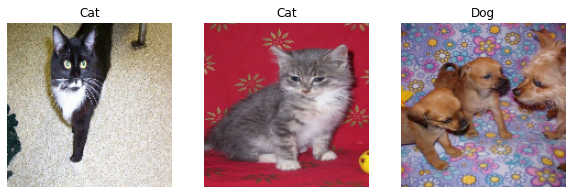

In [65]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Réseau de Neuronnes Convolutionnel

In [67]:
from tensorflow.keras import layers

num_classes = 2

model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),#normalise de 0 a 1
    layers.Conv2D(128,4, activation='relu'),
    layers.MaxPooling2D(),#réduit l'image
    layers.Conv2D(64,4, activation='relu'),
    layers.MaxPooling2D(),#prend le max du pooling
    layers.Conv2D(32,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16,4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),#permet de construire un vecteur
    layers.Dense(64,activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'],)

#logdir="logs"

#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_images=logdir,
                                                   #embeddings_data=train_data)

model.fit( 
    train_data,
  validation_data=val_data,
  epochs=2
)

Epoch 1/2
 16/200 [=>............................] - ETA: 17:23 - loss: 0.6957 - accuracy: 0.5181

InvalidArgumentError:  assertion failed: [Unable to decode bytes as JPEG, PNG, GIF, or BMP]
	 [[{{node decode_image/cond_jpeg/else/_1/decode_image/cond_jpeg/cond_png/else/_20/decode_image/cond_jpeg/cond_png/cond_gif/else/_39/decode_image/cond_jpeg/cond_png/cond_gif/Assert/Assert}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_16143]

Function call stack:
train_function


In [32]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 147, 147, 128)     6272      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 73, 73, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 70, 70, 64)        131136    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        32800     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 32)       